In [32]:
%load_ext autoreload
%autoreload 2

if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    sys.path.append(str(curr_file_path.parent))

import numpy as np
import glob2 as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import PCA
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from aux_funcs import colored_line, compressed_read, logical_and, compressed_write, format_plot, add_pc_axes, format_pc_plot, make_path_if_not_exists, cum_sum, compute_cosine_sims
from nb_analysis_tools import load_hidden_and_behavior
from agents.networks.a2c_rnn_split_vanilla import A2CRNN
import torch

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['font.family'] = 'Helvetica Light'

color_high_reward = '#d95f02'
color_low_reward = '#1b9e77'
color_unrewarded = '#7570b3'
color_intersite = '#808080'
color_interpatch = '#b3b3b3'

odor_colors = [
    color_unrewarded,
    color_low_reward,
    color_high_reward,
]

DATA_BASE_DIR = '../../results/rl_agent_outputs'
PATCH_TYPES_PER_ENV = 3
OBS_SIZE = PATCH_TYPES_PER_ENV + 1
ACTION_SIZE = 2
HIDDEN_SIZE = 128
NUM_ENVS = 30
DEVICE = 'cuda'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
dir_path = '../../results/rl_agent_outputs/test_he_init_linear_603284_2550_2025-07-09_09_35_34_648819_var_noise_0.0_activity_weight_1'

weight_path = 'he_init_vanilla_inoise_0p05_2025-07-06_15_02_35_603284_var_noise_0.0001_activity_weight_1/rnn_weights/02550.pth'

In [43]:
hidden, pc_activities, all_session_data, flattened_hidden, pca = load_hidden_and_behavior(dir_path)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
00000.pkl
00001.pkl
00002.pkl
00003.pkl
00004.pkl
00005.pkl
00006.pkl
00007.pkl


In [44]:
def extract_states_for_val(hidden_activities, all_session_data, var, in_patch=False):
    vals = np.arange(16)
    states_for_each_val = [[] for x in vals]
    for env_i in range(len(all_session_data)):
        session_data = all_session_data[env_i]
        for i_v, val in enumerate(vals):
            in_patch_mask = session_data['agent_in_patch'] == 1
            mask = logical_and(in_patch_mask, session_data[var] == val)
            hidden_for_mask = hidden_activities[:, env_i, mask].mean(axis=-1)
            states_for_each_val[i_v].append(hidden_for_mask)
    return states_for_each_val

In [45]:
states_for_each_val = extract_states_for_val(hidden, all_session_data, 'rewards_seen_in_patch')

### Plot average state for each value of acc. reward

Text(0.5, 1.0, 'Avg. unit activity as function of acc. reward')

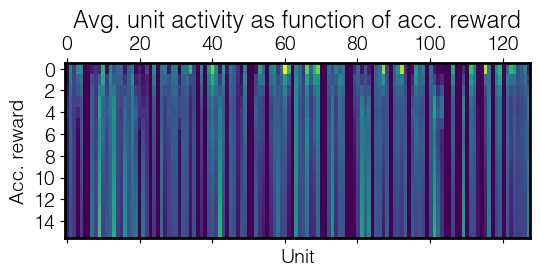

In [46]:
scale = 3
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale))
state_rep = np.stack([np.stack(s).mean(axis=0) for s in states_for_each_val])
axs.matshow(state_rep, aspect=3)
axs.set_xlabel('Unit')
axs.set_ylabel('Acc. reward')
axs.set_title('Avg. unit activity as function of acc. reward')

Axes(0.125,0.11;0.775x0.77)


Text(0.5, 1.0, 'Avg. unit activity as function of acc. reward')

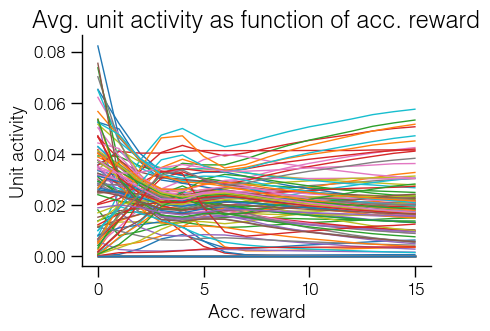

In [47]:
scale = 3
fig, axs = plt.subplots(1, 1, figsize=(1.5 * scale, 1 * scale))
state_rep = np.stack([np.stack(s).mean(axis=0) for s in states_for_each_val])
axs.plot(np.arange(state_rep.shape[0]), state_rep, lw=1)
format_plot(axs)
axs.set_ylabel('Unit activity')
axs.set_xlabel('Acc. reward')
axs.set_title('Avg. unit activity as function of acc. reward')

### Selecting for units whose activity varies substantially across these different average states

Text(0.5, 1.0, 'Avg. unit activity as function of acc. reward\n(high variance units only)')

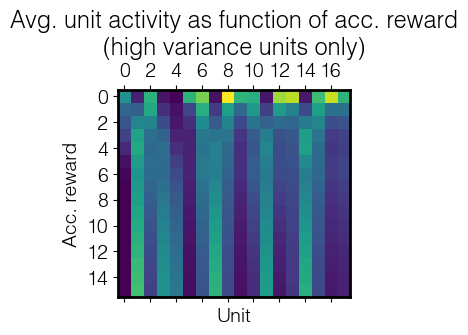

In [48]:
scale = 1.5
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale))
state_rep = np.stack([np.stack(s).mean(axis=0) for s in states_for_each_val])

unit_variance_across_reps = np.var(state_rep, axis=0)
axs.matshow(state_rep[:, unit_variance_across_reps > 1e-4], aspect=1)
axs.set_xlabel('Unit')
axs.set_ylabel('Acc. reward')
axs.set_title('Avg. unit activity as function of acc. reward\n(high variance units only)')

### Pull out units whose activity decreases as acc. reward increases and those whose activity decreases

(16, 38)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


Text(0.5, 1.0, 'Avg. unit activity as function of acc. reward\n(downward trending)')

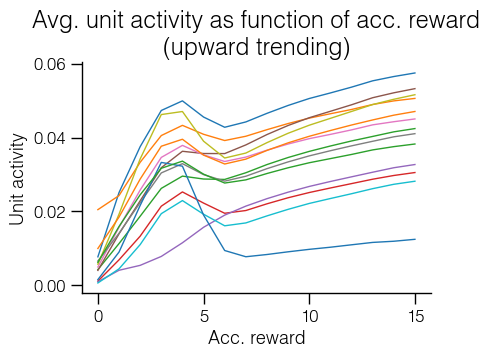

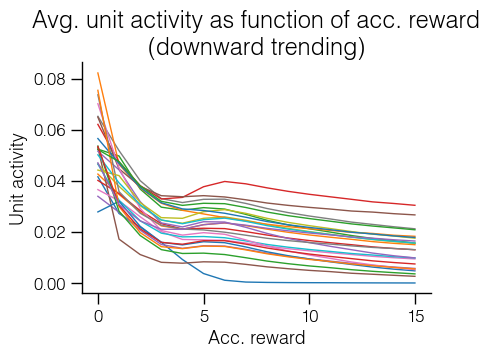

In [49]:
unit_activities_high_var_across_reps = state_rep[:, unit_variance_across_reps > 5e-5]

print(unit_activities_high_var_across_reps.shape)

diff = unit_activities_high_var_across_reps[-1, :] - unit_activities_high_var_across_reps[0, :]

scale = 3
fig, axs = plt.subplots(1, 1, figsize=(1.5 * scale, 1 * scale))
axs.plot(np.arange(unit_activities_high_var_across_reps[:, diff > 0].shape[0]), unit_activities_high_var_across_reps[:, diff > 0], lw=1)
format_plot(axs)
axs.set_ylabel('Unit activity')
axs.set_xlabel('Acc. reward')
axs.set_title('Avg. unit activity as function of acc. reward\n(upward trending)')

scale = 3
fig, axs = plt.subplots(1, 1, figsize=(1.5 * scale, 1 * scale))
axs.plot(np.arange(unit_activities_high_var_across_reps[:, diff < 0].shape[0]), unit_activities_high_var_across_reps[:, diff < 0], lw=1)
format_plot(axs)
axs.set_ylabel('Unit activity')
axs.set_xlabel('Acc. reward')
axs.set_title('Avg. unit activity as function of acc. reward\n(downward trending)')

### Repeat above analysis for reward site index

In [10]:
states_for_each_val = extract_states_for_val(hidden, all_session_data, 'reward_site_idx')

Text(0.5, 1.0, 'Avg. unit activity as function of reward site index')

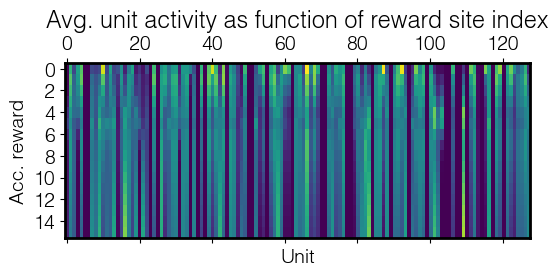

In [11]:
scale = 3
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale))
state_rep = np.stack([np.stack(s).mean(axis=0) for s in states_for_each_val])
axs.matshow(state_rep, aspect=3)
axs.set_xlabel('Unit')
axs.set_ylabel('Acc. reward')
axs.set_title('Avg. unit activity as function of reward site index')

Axes(0.125,0.11;0.775x0.77)


Text(0.5, 1.0, 'Avg. unit activity as function of reward site index')

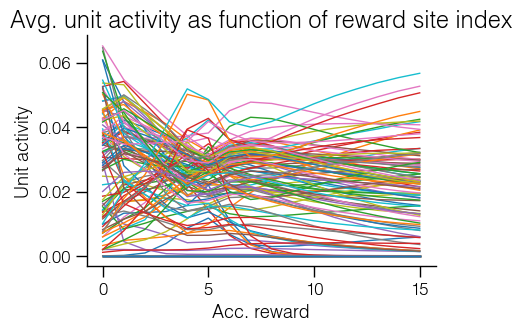

In [12]:
scale = 3
fig, axs = plt.subplots(1, 1, figsize=(1.5 * scale, 1 * scale))
state_rep = np.stack([np.stack(s).mean(axis=0) for s in states_for_each_val])
axs.plot(np.arange(state_rep.shape[0]), state_rep, lw=1)
format_plot(axs)
axs.set_ylabel('Unit activity')
axs.set_xlabel('Acc. reward')
axs.set_title('Avg. unit activity as function of reward site index')

Text(0.5, 1.0, 'Avg. unit activity as function of reward site index\n(high variance units only)')

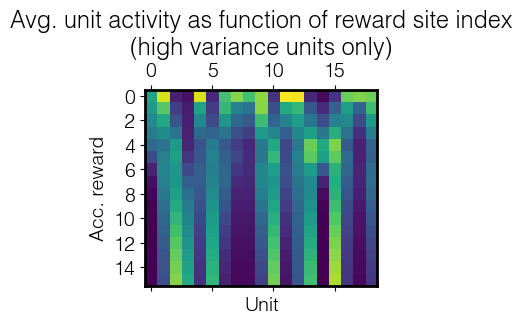

In [13]:
scale = 1.5
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale))
state_rep = np.stack([np.stack(s).mean(axis=0) for s in states_for_each_val])

unit_variance_across_reps = np.var(state_rep, axis=0)
axs.matshow(state_rep[:, unit_variance_across_reps > 1e-4], aspect=1)
axs.set_xlabel('Unit')
axs.set_ylabel('Acc. reward')
axs.set_title('Avg. unit activity as function of reward site index\n(high variance units only)')

(16, 42)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


Text(0.5, 1.0, 'Avg. unit activity as function of reward site index\n(downward trending)')

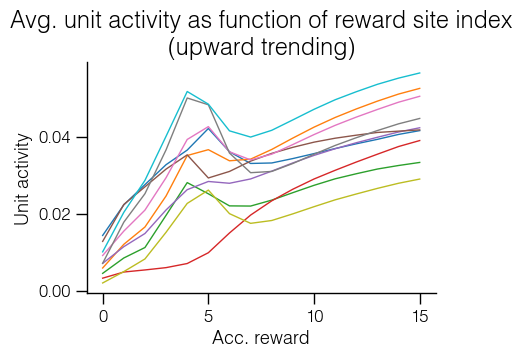

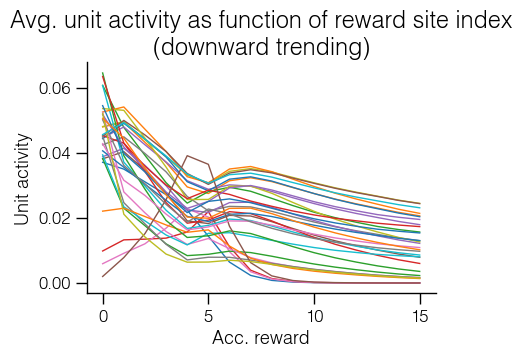

In [14]:
unit_activities_high_var_across_reps = state_rep[:, unit_variance_across_reps > 5e-5]

print(unit_activities_high_var_across_reps.shape)

diff = unit_activities_high_var_across_reps[-1, :] - unit_activities_high_var_across_reps[0, :]

scale = 3
fig, axs = plt.subplots(1, 1, figsize=(1.5 * scale, 1 * scale))
axs.plot(np.arange(unit_activities_high_var_across_reps[:, diff > 0].shape[0]), unit_activities_high_var_across_reps[:, diff > 0], lw=1)
format_plot(axs)
axs.set_ylabel('Unit activity')
axs.set_xlabel('Acc. reward')
axs.set_title('Avg. unit activity as function of reward site index\n(upward trending)')

scale = 3
fig, axs = plt.subplots(1, 1, figsize=(1.5 * scale, 1 * scale))
axs.plot(np.arange(unit_activities_high_var_across_reps[:, diff < 0].shape[0]), unit_activities_high_var_across_reps[:, diff < 0], lw=1)
format_plot(axs)
axs.set_ylabel('Unit activity')
axs.set_xlabel('Acc. reward')
axs.set_title('Avg. unit activity as function of reward site index\n(downward trending)')

### What does the connectivity between these high variance units look like?

In [30]:
def load_network(load_path):
    
    network = A2CRNN(
        input_size=OBS_SIZE + ACTION_SIZE + 1,
        action_size=ACTION_SIZE,
        hidden_size=HIDDEN_SIZE,
        device=DEVICE,
        var_noise=0,
    )

    saved_checkpoint = torch.load(os.path.join(DATA_BASE_DIR, load_path).replace('\\','/'), weights_only=True)
    if 'network_state_dict' in saved_checkpoint:
        network.load_state_dict(saved_checkpoint['network_state_dict'])
    else:
        network.load_state_dict(saved_checkpoint)
    network.eval()

    return network

In [33]:
network = load_network(weight_path)

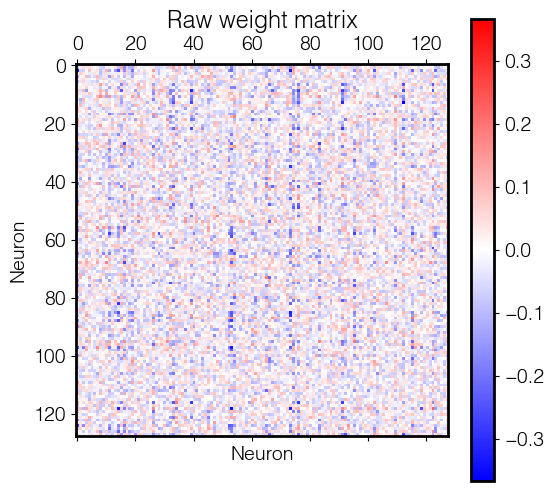

In [102]:
scale = 3
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
w_hh = network.rnn.weight_hh.detach().cpu().numpy()
cbar = axs.matshow(w_hh, vmin=-np.abs(w_hh).max(), vmax=np.abs(w_hh).max(), cmap='bwr')
axs.set_title('Raw weight matrix')
axs.set_xlabel('Neuron')
axs.set_ylabel('Neuron')
fig.colorbar(cbar)

Axes(0.125,0.11;0.775x0.77)


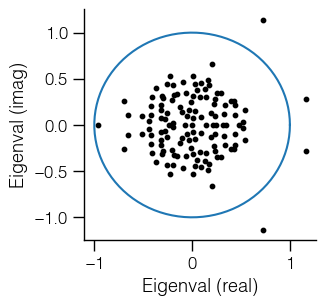

In [136]:
scale = 1.5
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
res = np.linalg.eig(w_hh)
eigen_vals = res.eigenvalues
axs.scatter(eigen_vals.real, eigen_vals.imag, s=10, c='black')
x = np.linspace(0, 2 * np.pi, 100)
axs.plot(np.cos(x), np.sin(x))
axs.set_xlabel('Eigenval (real)')
axs.set_ylabel('Eigenval (imag)')
format_plot(axs)

Text(0.5, 0, 'Acc. reward corr. neuron')

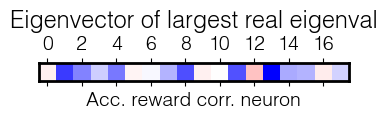

In [143]:
a = res.eigenvectors[high_variance_across_reps_mask, 0]

scale = 2
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
axs.matshow(a.real[None, :], vmin=-0.1, vmax=0.1, cmap='bwr')
axs.set_yticks([])
axs.set_title('Eigenvector of largest real eigenval')
axs.set_xlabel('Acc. reward corr. neuron')

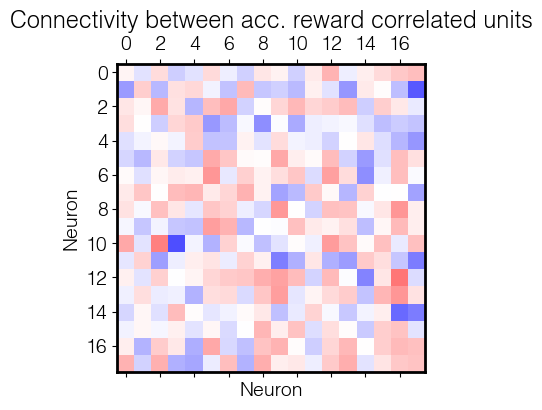

In [104]:
high_variance_across_reps_mask = (unit_variance_across_reps > 1e-4)
scale = 2
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
w_hh = network.rnn.weight_hh.detach().cpu().numpy()
w_hh_high_var_across_reps = w_hh[high_variance_across_reps_mask, :][:, high_variance_across_reps_mask]
axs.matshow(w_hh_high_var_across_reps, vmin=-np.abs(w_hh).max(), vmax=np.abs(w_hh).max(), cmap='bwr')
axs.set_title('Connectivity between acc. reward correlated units')
axs.set_xlabel('Neuron')
axs.set_ylabel('Neuron')

res = np.linalg.eig(w_hh_high_var_across_reps)

Axes(0.125,0.11;0.775x0.77)


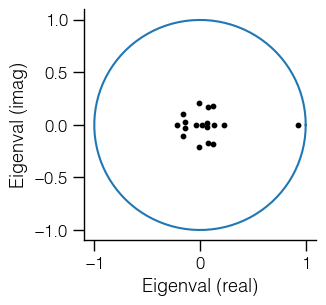

In [114]:
scale = 1.5
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
res = np.linalg.eig(w_hh_high_var_across_reps)
eigen_vals = res.eigenvalues
axs.scatter(eigen_vals.real, eigen_vals.imag, s=10, c='black')
x = np.linspace(0, 2 * np.pi, 100)
axs.plot(np.cos(x), np.sin(x))
axs.set_xlabel('Eigenval (real)')
axs.set_ylabel('Eigenval (imag)')
format_plot(axs)

Text(0.5, 0, 'Acc. reward corr. neuron')

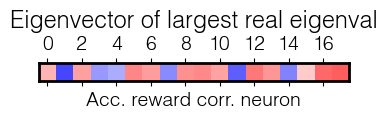

In [129]:
scale = 2
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
axs.matshow(res.eigenvectors[:, 0][:, None].real.T, vmin=-0.5, vmax=0.5, cmap='bwr')
axs.set_yticks([])
axs.set_title('Eigenvector of largest real eigenval')
axs.set_xlabel('Acc. reward corr. neuron')

Text(0.5, 1.0, 'Difference between 0 and 15 acc. reward states')

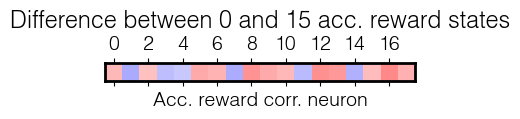

In [145]:
scale = 2
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
state_rep_high_var = state_rep[:, unit_variance_across_reps > 1e-4]
axs.matshow(-(state_rep_high_var[-1:, :] - state_rep_high_var[:1, :]), vmin=-0.15, vmax=0.15, cmap='bwr')
axs.set_yticks([])
axs.set_xlabel('Acc. reward corr. neuron')
axs.set_title('Difference between 0 and 15 acc. reward states')

In [146]:
write_path = os.path.join(dir_path, 'stored_pcs_and_weights')
make_path_if_not_exists(write_path)
compressed_write(-(state_rep_high_var[-1:, :] - state_rep_high_var[:1, :]), os.path.join(write_path, f'rewards_seen_in_patch_vec.pkl').replace('\\','/'))

In [134]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u)*np.linalg.norm(v))

In [135]:
cosine(-(state_rep_high_var[-1, :] - state_rep_high_var[0, :]), res.eigenvectors[:, 0].real)

0.9653065

In [67]:
w_ih = network.rnn.weight_ih.detach().cpu().numpy()

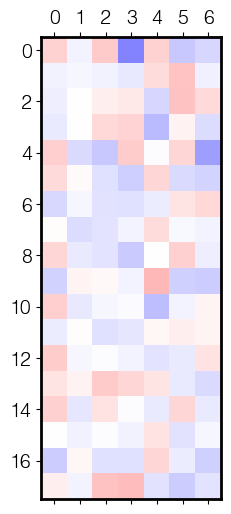

In [70]:
scale = 3
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
axs.matshow(w_ih[unit_variance_across_reps > 1e-4, :], vmin=-np.abs(w_hh).max(), vmax=np.abs(w_hh).max(), cmap='bwr')

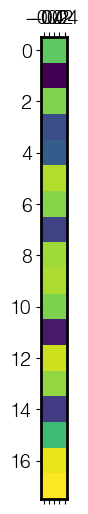

In [71]:
fig, axs = plt.subplots(1, 1, figsize=(2 * scale, 2 * scale), sharex=True)
axs.matshow(res.eigenvectors[:, 0][:, None].real)

In [85]:
input_weights_to_attractor_units = w_ih[unit_variance_across_reps > 1e-4, :].T

normed_input_weights_to_attractor_units = input_weights_to_attractor_units


np.dot(normed_input_weights_to_attractor_units, res.eigenvectors[:, 0].real)

array([ 0.02219296,  0.0189104 ,  0.03855376, -0.04097811,  0.01418333,
       -0.11748541, -0.00783955], dtype=float32)

In [93]:
for i in range(7):
    print(np.dot(normed_input_weights_to_attractor_units[i, :] / np.sqrt(np.sum(np.square(normed_input_weights_to_attractor_units[i, :]))), res.eigenvectors[:, 0].real))

0.10161786
0.17917047
0.18756378
-0.15357569
0.059827518
-0.5177615
-0.033854067


In [96]:
print(np.array(res.eigenvectors[:, 0].real))

[ 0.14669925 -0.36232823  0.18406871 -0.19969732 -0.16214018  0.23703201
  0.19322729 -0.22897018  0.21824428  0.23168854  0.18152624 -0.31337336
  0.26431298  0.20414703 -0.24472006  0.10477863  0.2947951   0.3153201 ]


In [95]:
unit_variance_across_reps > 1e-4

array([False, False, False,  True, False, False, False, False, False,
        True,  True, False, False, False, False, False,  True, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False,  True, False, False, False,  True, False,
       False, False, False, False, False,  True, False, False, False,
       False, False]